# Neural Network from Scratch

#### Tensorflow is only used for loading DATASET

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

2024-06-22 22:01:55.531220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 22:01:55.531265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 22:01:55.532405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-22 22:01:55.538029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 22:01:56.073649: W tensorflow/compiler/tf2

In [2]:
def one_hot(x, depth):
    res=[]
    for i in range(len(x)):
        tmp = [0 for i in range(depth)]
        tmp[x[i]] = 1
        tmp = np.array(tmp)
        res.append(tmp)
    res = np.array(res)
    return res

In [3]:
(train_data, train_label), (test_data, test_label) =mnist.load_data()

train_data = train_data.reshape((60000, 28*28))
test_data = test_data.reshape((10000, 28*28))

test_label = one_hot(test_label, 10)
train_label = one_hot(train_label, 10)

In [4]:
train_data = train_data / 255

In [5]:
class Input():
    def __init__(self, shape):
        self.type = "Input"
        self.shape = shape
        
    def operate(self, x):
        self.Z = np.array(x, copy=True)
        return self.Z
        
class Dense():
    def __init__(self, shape, prev):
        self.type = "Dense"
        self.shape = shape
        self.prev = prev
        self.W = np.random.uniform(-.5, .5, size=(self.shape, self.prev.shape))
        self.B = np.random.uniform(-.5, .5,size=self.shape)
        self.grad_W = np.zeros((self.shape, self.prev.shape))
        self.grad_Z = np.zeros(self.prev.shape)
        self.grad_B = np.zeros(shape)
        
    def operate(self, x):
        self.Z = np.matmul(self.W, x) + self.B
        return relu(self.Z)
    
    def ret(self, x):
        return self.Z

class Output():
    def __init__(self, shape, prev):
        self.type = "Output"
        self.shape = shape
        self.prev = prev
        self.W = np.random.uniform(-.5, .5, size=(self.shape, self.prev.shape))
        self.B = np.random.uniform(-.5, .5,size=self.shape)
        self.grad_W = np.zeros((self.shape, self.prev.shape))
        self.grad_Z = np.zeros(self.prev.shape)
        self.grad_B = np.zeros(shape)
        self.grad_loss = np.zeros(shape)
        
    def operate(self, x):
        self.Z = np.matmul(self.W, x) + self.B
        return softmax(self.Z)
    
    def ret(self, x):
        return self.Z

In [6]:
def relu(x):
    return np.maximum(0,x)

def softmax(X):
    Z = X - np.max(X)
    return np.exp(Z)/(np.sum(np.exp(Z), axis=0))

def grad_Z(w, z_curr, z_prev, dz_next, act):        #Calculating dLoss wrt dz_prev
    grad = np.zeros(z_prev.shape)
    if act == "relu":
        for i in range(z_prev.shape[0]):
            for j in range(z_curr.shape[0]):
                if z_curr[j] > 0:                   #coz dReLU/dZ whould be zero
                    grad[i] += dz_next[j]*1*w[j][i]
    elif act == "softmax":
        for i in range(z_prev.shape[0]):
            for j in range(z_curr.shape[0]):
                for k in range(dz_next.shape[0]):
                    if k == j:
                        grad[i] += dz_next[k]*(softmax(z_curr)[k] - (softmax(z_curr)[k])**2)*w[j][i]
                    else:
                        grad[i] += dz_next[k]*(-1 * softmax(z_curr)[j] * softmax(z_curr)[k])*w[j][i]
    return grad
    
def grad_W(w, z_curr, z_prev, dz_next, act):         # Z = matmul(W,Z_prev) + B
    grad = np.zeros(w.shape)
    if act == "relu":
        for j in range(w.shape[0]):
            if z_curr[j] > 0:                       #coz dReLU/dZ whould be zero
                for i in range(w.shape[1]):
                    grad[j][i] = dz_next[j]*1*z_prev[i]
    elif act == "softmax":
        for j in range(w.shape[0]):
            for i in range(w.shape[1]):
                for k in range(dz_next.shape[0]):
                    if j == k:
                        grad[j][i] += dz_next[k]*(softmax(z_curr)[k] - (softmax(z_curr)[k])**2)*z_prev[i]
                    else:
                        grad[j][i] += dz_next[k]*(-1 * softmax(z_curr)[j] * softmax(z_curr)[k])*z_prev[i]
    return grad

def grad_B(b, z_curr, dz_next, act):
    grad = np.zeros(b.shape)
    if act == "relu":
        for j in range(b.shape[0]):
            if z_curr[j] > 0:                       #coz dReLU/dZ whould be zero
                grad[j] =  dz_next[j] * 1 * 1
    elif act == "softmax":
        for j in range(b.shape[0]):
            for k in range(dz_next.shape[0]):
                if j == k:
                    grad[j] += dz_next[k]*(softmax(z_curr)[k] - (softmax(z_curr)[k])**2)*1
                else:
                    grad[j] += dz_next[k]*(-1 * softmax(z_curr)[j] * softmax(z_curr)[k])*1
    return grad

In [15]:
class model():
    def __init__(self):
        self.step_size = 0.01
        self.epochs = 2
        self.m = 32
        self.batch_acc = []
    
    def make(self, inputs, outputs, optimizer):
        self.comp_graph = []
        self.input_layer = inputs
        self.output_layer = outputs
        i = outputs
        while i.type != "Input":
            self.comp_graph.append(i)
            i=i.prev
        
        if (optimizer == "adam"):
            self.adam_init()
            self.optimizer = self.adam
        else:
            self.step_size = 0.01
            self.optimizer = self.SGD
            
    def SGD(self, x, grad, layer, sub_typ):
        return (x - self.step_size*grad)
        
    def adam_init(self):
        #Hyper Parameters
        self.a = 0.1
        self.b1 = 0.9
        self.b2 = 0.999
        self.e = 10e-8
        
        #t, m, v STORING THE HISTORY
        self.pram = {i:{'W':{'t':0, 'm':np.zeros(i.W.shape), 'v':np.zeros(i.W.shape)},
                        'B':{'t':0, 'm':np.zeros(i.B.shape), 'v':np.zeros(i.B.shape)}} for i in self.comp_graph}
        
    def adam(self, x, grad, layer, sub_typ):
        self.pram[layer][sub_typ]['t'] += 1
        self.pram[layer][sub_typ]['m'] = self.b1 * self.pram[layer][sub_typ]['m'] + (1-self.b1) * (np.power(grad,1))
        self.pram[layer][sub_typ]['v'] = self.b2 * self.pram[layer][sub_typ]['v'] + (1-self.b2) * (np.power(grad,2))
        corr_m = self.pram[layer][sub_typ]['m']/(1 - np.power(self.b1, self.pram[layer][sub_typ]['t']))
        corr_v = self.pram[layer][sub_typ]['v']/(1 - np.power(self.b2, self.pram[layer][sub_typ]['t']))
        x = x - self.a * (corr_m/(np.add(np.power(corr_v, 0.5), self.e)))
        return x
            
    def fit(self, X, Y):
        
        Y.flags.writeable = False
        X.flags.writeable = False
        correct_pred = 0

        for i in range(len(X)):
            #forward pass
            i_copy = i
            i = i%self.m
            
            x = self.input_layer.operate(X[i])
            for j in range(-1, -1*len(self.comp_graph)-1, -1):
                x = self.comp_graph[j].operate(x)

            if np.argmax(x) == np.argmax(Y[i]):
                correct_pred += 1

            for e in range(self.epochs):
                #backward pass
                #Signatures
                #grad_W(w, z_curr, z_prev, dz_next, act)
                #grad_B(b, z_curr, dz_next, act)
                self.output_layer.grad_loss = (-2)*(Y[i] - softmax(self.output_layer.Z))/len(Y[i])
                
                self.output_layer.grad_W = grad_W(self.output_layer.W, self.output_layer.Z,
                                                  self.output_layer.prev.Z, self.output_layer.grad_loss, "softmax")
                
                self.output_layer.grad_Z = grad_Z(self.output_layer.W, self.output_layer.Z,
                                                  self.output_layer.prev.Z, self.output_layer.grad_loss, "softmax")
                
                self.output_layer.grad_B = grad_B(self.output_layer.B,
                                                  self.output_layer.Z ,self.output_layer.grad_loss, "softmax")
 
                self.output_layer.W = self.optimizer(self.output_layer.W, self.output_layer.grad_W,
                                                     self.output_layer, "W")
                self.output_layer.B = self.optimizer(self.output_layer.B, self.output_layer.grad_B,
                                                     self.output_layer, "B")
                    
                self.comp_graph.append(self.comp_graph[-1].prev) #Quick Fix, Don't Look Here :-D
                
                for k in range(1, len(self.comp_graph)-1):
                    self.comp_graph[k].grad_W = grad_W(self.comp_graph[k].W, self.comp_graph[k].Z,
                                                       self.comp_graph[k+1].Z, self.comp_graph[k-1].grad_Z, "relu")
                    
                    self.comp_graph[k].grad_Z = grad_Z(self.comp_graph[k].W, self.comp_graph[k].Z,
                                                       self.comp_graph[k+1].Z, self.comp_graph[k-1].grad_Z, "relu")
                    
                    self.comp_graph[k].grad_B = grad_B(self.comp_graph[k].B,
                                                       self.comp_graph[k].Z, self.comp_graph[k-1].grad_Z, "relu")

                    self.comp_graph[k].W = self.optimizer(self.comp_graph[k].W, self.comp_graph[k].grad_W,
                                                     self.comp_graph[k], "W")
                    self.comp_graph[k].B = self.optimizer(self.comp_graph[k].B, self.comp_graph[k].grad_B,
                                                     self.comp_graph[k], "B")
                
                self.comp_graph.pop(-1)                         #Quick Fix, Don't Look Here :-D
            
            i = i_copy
            if (i%32 == 0):
                self.batch_acc.append(correct_pred/32)
                print(correct_pred/32, "Total Processed", i)
                correct_pred = 0
    
    def predict (self, X):
        x = self.input_layer.operate(X)
        for i in range(-1, -1*len(self.comp_graph)-1, -1):
            x = self.comp_graph[i].operate(x)
        return x

In [20]:
'''
For adding new layer just put the "output size" the input size 
will be ajusted automatically from the prev layer output
'''

inputs = Input(28*28)
x = Dense(28*2 ,inputs)
outputs = Output(10 ,x)

digit_classifier = model()

# Testing SGD And Adam with same weights initialization
##### SGD doesn't learn well with small steps but Adam works well with small steps

In [24]:
inputs = Input(28*28)
x = Dense(28*2 ,inputs)
outputs = Output(10 ,x)

digit_classifier = model()

x_W = x.W
x_B = x.B

outputs_W = outputs.W
outputs_B = outputs.B

In [25]:

# SGD

digit_classifier.make(inputs=inputs, outputs=outputs, optimizer="SGD")
digit_classifier.step_size = 0.1      #Step size if you are using SGD
digit_classifier.epochs = 1           #No of Epochs
digit_classifier.a = 0.001            #Step size if you are using Adam
digit_classifier.m = 9999999          #This will repeat the images starting from image 0 to m-1 in train set
                                      #This heps me to check if the model is atleast overfitting

digit_classifier.fit(train_data[:5000], train_label[:5000])

0.0 Total Processed 0
0.125 Total Processed 32
0.21875 Total Processed 64
0.28125 Total Processed 96
0.34375 Total Processed 128
0.125 Total Processed 160
0.40625 Total Processed 192
0.34375 Total Processed 224
0.3125 Total Processed 256
0.40625 Total Processed 288
0.375 Total Processed 320
0.34375 Total Processed 352
0.375 Total Processed 384
0.46875 Total Processed 416
0.53125 Total Processed 448
0.375 Total Processed 480
0.21875 Total Processed 512
0.4375 Total Processed 544
0.40625 Total Processed 576
0.3125 Total Processed 608
0.34375 Total Processed 640
0.375 Total Processed 672
0.3125 Total Processed 704
0.4375 Total Processed 736
0.28125 Total Processed 768
0.375 Total Processed 800
0.5 Total Processed 832
0.34375 Total Processed 864
0.28125 Total Processed 896
0.40625 Total Processed 928
0.34375 Total Processed 960
0.5 Total Processed 992
0.4375 Total Processed 1024
0.375 Total Processed 1056
0.34375 Total Processed 1088
0.5 Total Processed 1120
0.46875 Total Processed 1152
0.

##          Testing on ALL 10,000 samples in test set for SGD

In [27]:
correct_count = 0

for i in range(len(test_data)):
    if np.argmax(digit_classifier.predict(test_data[i])) == np.argmax(test_label[i]):
        correct_count += 1
print(f"Accuracy: {correct_count/len(test_data)}")

Accuracy: 0.8004


In [35]:
len(SGD_performance)

157

In [31]:
SGD_performance = digit_classifier.batch_acc
digit_classifier.batch_acc = []

x.W = x_W
x.B = x_B

outputs.W = outputs_W
outputs.B = outputs_B

In [36]:

# Adam

digit_classifier.make(inputs=inputs, outputs=outputs, optimizer="adam")
digit_classifier.step_size = 0.001
digit_classifier.epochs = 1
digit_classifier.a = 0.001
digit_classifier.m = 9999999

digit_classifier.fit(train_data[:5000], train_label[:5000])

Adam_performance = digit_classifier.batch_acc

0.0 Total Processed 0
0.1875 Total Processed 32
0.21875 Total Processed 64
0.21875 Total Processed 96
0.40625 Total Processed 128
0.21875 Total Processed 160
0.40625 Total Processed 192
0.3125 Total Processed 224
0.34375 Total Processed 256
0.40625 Total Processed 288
0.40625 Total Processed 320
0.4375 Total Processed 352
0.46875 Total Processed 384
0.53125 Total Processed 416
0.65625 Total Processed 448
0.5625 Total Processed 480
0.28125 Total Processed 512
0.5 Total Processed 544
0.5 Total Processed 576
0.5 Total Processed 608
0.46875 Total Processed 640
0.46875 Total Processed 672
0.4375 Total Processed 704
0.5625 Total Processed 736
0.5 Total Processed 768
0.53125 Total Processed 800
0.78125 Total Processed 832
0.5625 Total Processed 864
0.5 Total Processed 896
0.59375 Total Processed 928
0.65625 Total Processed 960
0.65625 Total Processed 992
0.59375 Total Processed 1024
0.59375 Total Processed 1056
0.59375 Total Processed 1088
0.6875 Total Processed 1120
0.5625 Total Processed 11

# Testing on all 10,000 samples in Test dataset

In [53]:
correct_count = 0

for i in range(len(test_data)):
    if np.argmax(digit_classifier.predict(test_data[i])) == np.argmax(test_label[i]):
        correct_count += 1
print(f"Accuracy: {correct_count/len(test_data)}")

Accuracy: 0.8598


# Performance SGD vs Adam

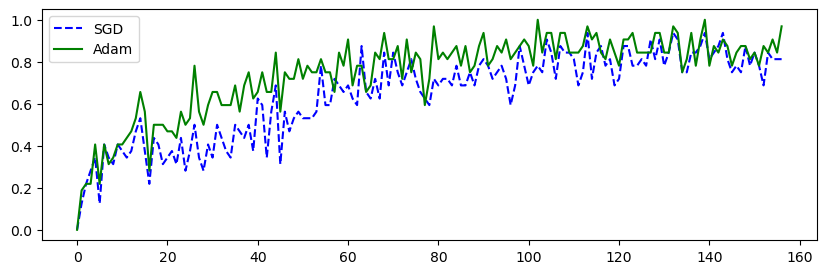

In [56]:
plt.figure(figsize=(10, 3))
plt.plot(range(len(SGD_performance)), SGD_performance, 'b--', label = "SGD")
plt.plot(range(len(Adam_performance)), Adam_performance, 'g-', label = "Adam")
plt.legend()
plt.show()

Accuracy: 0.89
9 1 3 4 4 5 7 0 9 5 
5 2 2 2 3 6 9 3 2 4 
9 3 8 6 5 3 4 6 4 5 
3 3 6 0 0 8 6 0 7 3 
8 3 2 5 1 8 9 2 3 4 
6 6 3 5 2 1 2 6 1 2 
6 3 7 6 5 1 4 7 2 9 
9 6 7 9 6 8 9 3 7 1 
7 4 3 3 1 6 9 4 8 5 
9 2 2 1 1 4 1 8 8 8 


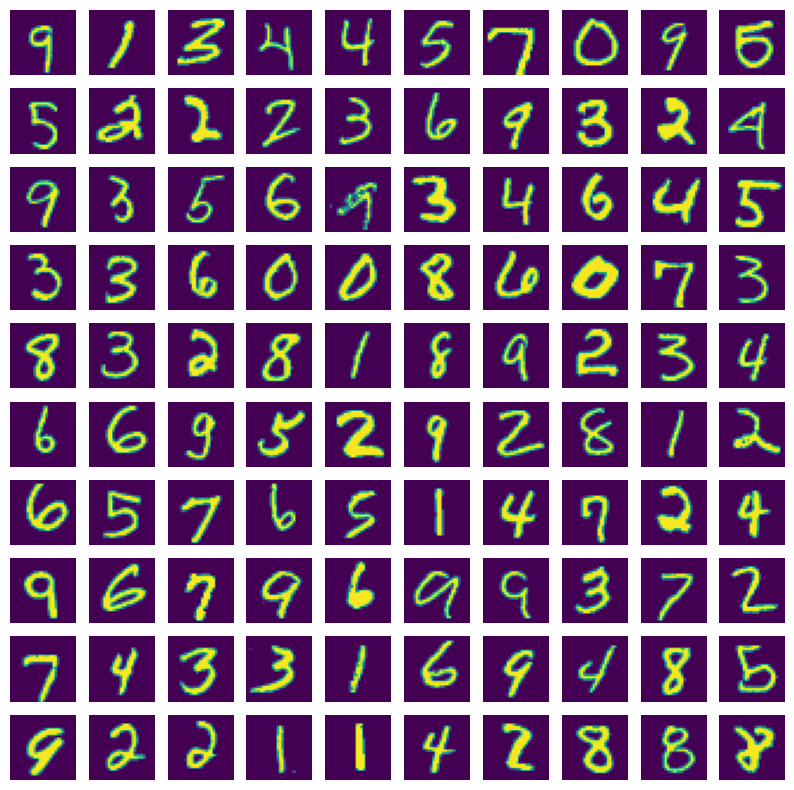

In [57]:
#TESTING ON 100 RANDOM SAMPLES

num_samples = test_data.shape[0]
random_indices = np.random.choice(num_samples, 100, replace=False)

X_sample = test_data[random_indices]
y_sample = test_label[random_indices]
predictions = []
correct_count = 0

plt.figure(figsize=( 10, 10))
for i in range(len(X_sample)):
    ax = plt.subplot(10, 10, i+1)
    plt.imshow((X_sample[i]).reshape((28,28)))
    predictions.append(np.argmax(digit_classifier.predict(X_sample[i])))
    if predictions[i] == np.argmax(y_sample[i]):
        correct_count += 1
    plt.axis("off")

print(f"Accuracy: {correct_count/len(X_sample)}")
for i in range(10):
    for j in range (10):
        print(predictions[10*i+j],end=" ")
    print()


In [58]:
np.save("Dense_W",x.W)
np.save("Dense_B",x.B)
np.save("Output_W",outputs.W)
np.save("Output_B",outputs.B)

In [ ]:
'''
Do not execute this cell. Basically i did a "quick fix" in the BackProp, sometimes if the code is intruptted in
the BackProp then we need to manually remove the input layer from the comp_graph so we can run the code without
reinitializing the weights
'''
digit_classifier.comp_graph.pop(-1)